# 5EL272 Systems and algorithms for Autonomous Vehicles
## Exercise 2: Point cloud (3D) object detection in BEV feature space
Created by Junjie Wang & Tomas Nordström, Umeå University

## Revisions:

* 2024-11-28 First version /Junjie
* 2024-11-30 Review and cleanup /Tomas
* 2024-11-30 Update some training tricks, change datasets, Commenting /Junjie
* 2024-12-01 Adding AP calculation, and cleanup around that /Junjie
* 2024-12-03 Optimization of the bottleneck: voxelization /Tomas
* 2024-12-04 Cleanup before release to students /Tomas
* 2024-12-06 Implemented a just-in-time (jit) compilation of voxelize. /Junjie
* 2024-12-08 Realized that we need to do (workers=1, use_multiprocessing=False) when reding the database on T4. /Junjie

*With the jit voxilization and (workers=1, use_multiprocessing=False) for the LidarDetectionDataset, we got a speedup of around 2x, from the original code*.

##**YOUR NAME**:Rickard Sörlin

### Exercise Goals

In this lab, you will gain hands-on experience in building a 3D object detector using the point clouds modality. By completing this exercise, you will:

1. **Understand 3D Object Detection Fundamentals**  
   Gain a foundational understanding of 3D object detection principles, focusing on point clouds modality.

2. **Understand the consept of Bird's eye view (BEV) features for Autonomous driving**  
   Understand the concept of projecting 3D point clouds into a 2D bird's-eye view (BEV) representation.

3. **Explore and Implement Voxelization (converting point clouds to BEVs)**  
   Learn how to convert raw point clouds into a 3D voxel grid representation. Explore the advantages of voxelization for efficient 3D object detection.


For this lab, we will train a 3D object detector on the extracted subset of V2X-SIM dataset, which contains 401 frames for fine-tuning.
The extracted subset only contains one type of targets (cars).

## Code summary
The code for this exercise consists of the following steps
1. Set up the dataset used V2X-SIM database
2. Helper functions to handle bounding boxes, like change formats and plotting
3. Setting up the Input and BEV feature space
4. Data augmentation (by rotation)
4. Generate anchor box priors, with varying scales (sizes) and yaw-rotation
6. Function to encode offset between ground truth bounding boxes with anchors (for training)
5. Function to match ground truth bounding boxes with anchors
7. Function to convert database labels/targets to training labels (based on anchors)
8. Build a model, with the following parts:
    * Voxel Feature Encoding; Backbone using ResNet building blocks; Two output blocks: a Classifier and Bounding Box Regression
9. Define an object detection loss
10. Do the training

Evaluate
1. Do a prediction on unseen data
2. Implement a Non-Maximum Suppression function that can eliminate duplicate detections
3. Compute Average Precision

Among the code block there are a number of "**STUDENT Questions**" to look for! In connection to these questions we will also ask for some **STUDENT Code**

The main task for this Lab will be to explore hyper parameters that control the performance on this 3D object detection task.

As a bonus task we ask you to investigate a layer in your model.

# First setting up the Python Environment

In [334]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"  # must be set before importing keras

import keras
import tensorflow as tf

print("TF:", tf.__version__)
print("Keras:", keras.__version__)
print("GPUs:", tf.config.list_physical_devices("GPU"))


TF: 2.16.1
Keras: 3.3.3
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [335]:
#### Set up tests to know if we are running Colab or Kaggle
import sys, os

### Is this notebook running on Colab?
IS_COLAB = "google.colab" in sys.modules

### Is this notebook running on Kaggle?
# Fool Kaggle into making kaggle_secrets avaiable
try:
    import kaggle_secrets
except ImportError as e:
    pass
# Now we can test for Kaggle
IS_KAGGLE = "kaggle_secrets" in sys.modules

In [336]:
# setup and import some libraries
import os
# we made the codes to be backend agnostic, you can swith between different backends
os.environ["KERAS_BACKEND"] = "tensorflow" # @param ["tensorflow", "jax", "torch"]
# Note that jax seems to lockup during traning, we hvae not had time to investigate yet. /Tomas# Import Keras/TF libraries

import keras
print('Keras version:', keras.__version__)

import tensorflow as tf
print('TensorFlow version:', tf.__version__)

import pickle
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

import time
import math
import zipfile
import gdown

import keras.ops as ops
from keras import layers

import pandas as pd
from scipy.special import softmax
from shapely.geometry import Polygon
# we use shapely libary to accurately calculate the iou of polygon.

Keras version: 3.3.3
TensorFlow version: 2.16.1


In [337]:
# Setting up for jit version of voxelize
if (IS_COLAB or IS_KAGGLE):
    !pip install numba

import numba
print('Numba version:', numba.__version__)

Numba version: 0.62.1


# Set up the Dataset
We are using a subset of the [V2X-SIM dataset](https://ai4ce.github.io/V2X-Sim/). Specifically, we extract data from agent 0 and project the corresponding labels onto agent 0's coordinate system. These projected labels are then converted into a representation of 8 corner points.

The input data is a vector of (x, y, z, intensity, colour) for each point in a scene.

In [338]:
# Class to download and provide the selected subset of the V2X-SIM database
class LidarDetectionDataset(keras.utils.PyDataset):
    # URL to download a subset of the V2X-SIM dataset
    url =  "https://drive.google.com/file/d/1eP1uOT3uo7eZyOGHLyyIhBe7kRKiXwrD/view?usp=sharing"

    def download(self) -> None:
        """
        Download and extract the V2X-SIM dataset if not already present locally.
        """
        file_name = "V2X-SIM_subset_agent0.zip"
        self.root = './V2X-SIM_subset_agent0'

        if os.path.exists(file_name): # Skip download if file already exists
            return

        # Download the file and extract the contents
        gdown.download(self.url, file_name, fuzzy=True)
        with zipfile.ZipFile(file_name) as archive:
            archive.extractall('./')

    @staticmethod
    def read_lidar(path, nbr_dims = 5):
        """
        Reads LiDAR data from a binary file and reshapes it into points.
        Parameters:
            path (str): Path to the LiDAR binary file.
            nbr_dims (int): Number of dimensions to keep from the point data.
        Returns:
            np.ndarray: The reshaped LiDAR points array.
        """
        scan = np.fromfile(path, dtype='float32')
        points = scan.reshape((-1, 5))[:, :nbr_dims]
        return points

    def mask_points_by_range(self, points):
        """
        Filters out LiDAR points outside a specified range.
        Parameters:
            points (np.ndarray): LiDAR points under the sensor's coordinate system.
        Returns:
            np.ndarray: Filtered LiDAR points.
        """
        mask =    (points[:, 0] > self.limit_range[0]) \
                & (points[:, 0] < self.limit_range[3]) \
                & (points[:, 1] > self.limit_range[1]) \
                & (points[:, 1] < self.limit_range[4]) \
                & (points[:, 2] > self.limit_range[2]) \
                & (points[:, 2] < self.limit_range[5])

        points = points[mask]
        return points

    def mask_boxes_outside_range(self, boxes):
        """
        Filters out bounding boxes that are completely outside a specified range.
        Parameters:
            boxes (np.ndarray): Array of bounding boxes with 8 vertices.
        Returns:
            np.ndarray: Filtered bounding boxes.
        """
        assert boxes.shape[1] == 8
        new_boxes = boxes.copy()
        mask = ((new_boxes >= self.limit_range[0:3]) &
                (new_boxes <= self.limit_range[3:6])).all(axis=2)

        # Filter boxes that have at least 8 valid points inside the range
        mask = mask.sum(axis=1) >= 8

        return boxes[mask]

    @staticmethod
    def shuffle_points(points):
        """
        Randomly shuffles the order of LiDAR points.
        """
        shuffle_idx = np.random.permutation(points.shape[0])
        points = points[shuffle_idx]
        return points

    def __init__(self, limit_range, batch_size=1, transforms = None, train = True, **kwargs):
        """
        Initializes the dataset.
        Parameters:
            limit_range (list): Range limits for filtering points and boxes.
            batch_size (int): Number of samples per batch.
            transforms (callable): Optional transform to be applied on a sample.
            train (bool): Flag to use training or validation split.
            **kwargs: Additional arguments passed to the parent class.
        """
        super().__init__(**kwargs)
        self.download()

        lidars = list(sorted(os.listdir(os.path.join(self.root, "lidars"))))
        targets = list(sorted(os.listdir(os.path.join(self.root, "targets"))))
        train_data_split = 0.8
        if train:
            self.lidars = lidars[: int(len(lidars) * train_data_split)]
            self.targets = targets[: int(len(lidars) * train_data_split)]
        else:
            self.lidars = lidars[int(len(lidars) * train_data_split):]
            self.targets = targets[int(len(lidars) * train_data_split):]
        self.batch_size = batch_size
        self.train = train
        # ToDo. Maybe we should check that limit_range is correct (like x_max>x_min)?
        self.limit_range = limit_range
        self.on_epoch_end()
        self.transforms = transforms

    def on_epoch_end(self):
        # shuffle
        self.indexes = np.arange(len(self.lidars))
        if self.train:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        """
        Retrieves a batch of samples.
        Parameters:
            index (int): Batch index.
        Returns:
            Tuple[List[np.ndarray], List[np.ndarray]]: Batched LiDAR points and target arrays.
        """
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]

        point_l = []
        target_l = []
        for k in indexes:
            points, targets = self.fetch_single(k)
            point_l.append(points)
            target_l.append(targets)

        return point_l, target_l

    def fetch_single(self, idx):
        """
        Fetches and processes a single sample.
        Parameters:
            idx (int): Sample index.
        Returns:
            Tuple[np.ndarray, np.ndarray]: Processed LiDAR points and targets.
        """
        lidar_path = os.path.join(self.root, "lidars", self.lidars[idx])
        target_path = os.path.join(self.root, "targets", self.targets[idx])
        points = self.read_lidar(lidar_path)
        targets = np.load(target_path)

        points = self.shuffle_points(points)
        if self.transforms is not None:
            points, targets = self.transforms(points, targets)
        points = self.mask_points_by_range(points)
        targets = self.mask_boxes_outside_range(targets)

        return points, targets

    def __len__(self):
        """
        Returns the total number of batches.
        """
        return len(self.lidars) // self.batch_size

# Helper Functions for Bounding Boxes

We have the 3D version of **box_center_to_corner** and **box_corner_to_center** as we used in laboratory 1.

And also we reuse the function **assign_anchor_to_bbox** in laboratory 1.

In [339]:
def vis_point_cloud_2d(points, bboxes=None, ax=None, figsize=(8, 8), color='r'):
    """
    Visualizes a 3D point cloud in 2d space.

    Args:
        points (np.ndarray): A NumPy array of shape (N, 3) representing the 2D points.
        bboxes (np.ndarray): An optional NumPy array of shape (N, 8, 3) representing the bounding boxes.
        ax (matplotlib.axes.Axes): A figure to add bboxes on, if None create a new figure with points
        figsize (tuple): A tuple specifying the figure size in inches.
        figsize : A tuple specifying the figure size in inches.
        color (str): The color of the points and bounding boxes.
    Returns:
        matplotlib.axes.Axes: The updated axes object, if we want to continu plotting boxes in the same figure
    """
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
        ax.scatter(points[:, 0], points[:, 1], s=1)
    if bboxes is not None:
        show_bboxes(ax, bboxes, color)
    return ax

def show_bboxes(axes, bboxes, color=None):
    """
    Plots 2D bounding boxes on the given axes.

    Args:
        axes: The matplotlib axes object to plot on.
        bboxes: A NumPy array of shape (N, 8, 3) representing the bounding boxes.
        color: The color of the bounding boxes.
    """

    bboxes_2d = bboxes[:,:4,:2]
    for bbox in bboxes_2d:
            rect = plt.Polygon(xy=bbox, fill=False, color=color)
            # Add the rectangle to the axes
            axes.add_patch(rect)

# This function is similar to what we did in 2D space
def box_corner_to_center(corner3d):
    """
    Converts 3D box corner coordinates to center-based representation.
    Parameters:
        corner3d (ndarray): 3D box corners (shape: Bx8x3, where B is batch size).
    Returns:
        ndarray: Converted center-based representation (shape: Bx7 [x, y, z, l, w, h, theta]).
    """
    assert corner3d.ndim == 3
    batch_size = corner3d.shape[0]

    # Calculate the center (x, y, z) as the mean of the bottom corners
    xyz = np.mean(corner3d[:, [0, 3, 5, 6], :], axis=1)

    # Compute height (h) as the difference between top and bottom Z coordinates
    h = abs(np.mean(corner3d[:, 4:, 2] - corner3d[:, :4, 2], axis=1,
                    keepdims=True)) # dz

    # Compute length (l) as the average distance along the X-axis between pairs of opposite corners
    l = (np.sqrt(np.sum((corner3d[:, 0, [0, 1]] - corner3d[:, 3, [0, 1]]) ** 2,
                        axis=1, keepdims=True)) +
         np.sqrt(np.sum((corner3d[:, 2, [0, 1]] - corner3d[:, 1, [0, 1]]) ** 2,
                        axis=1, keepdims=True)) +
         np.sqrt(np.sum((corner3d[:, 4, [0, 1]] - corner3d[:, 7, [0, 1]]) ** 2,
                        axis=1, keepdims=True)) +
         np.sqrt(np.sum((corner3d[:, 5, [0, 1]] - corner3d[:, 6, [0, 1]]) ** 2,
                        axis=1, keepdims=True))) / 4 # d

    # Compute width (w) as the average distance along the Y-axis between pairs of opposite corners
    w = (np.sqrt(
        np.sum((corner3d[:, 0, [0, 1]] - corner3d[:, 1, [0, 1]]) ** 2, axis=1,
               keepdims=True)) +
         np.sqrt(np.sum((corner3d[:, 2, [0, 1]] - corner3d[:, 3, [0, 1]]) ** 2,
                        axis=1, keepdims=True)) +
         np.sqrt(np.sum((corner3d[:, 4, [0, 1]] - corner3d[:, 5, [0, 1]]) ** 2,
                        axis=1, keepdims=True)) +
         np.sqrt(np.sum((corner3d[:, 6, [0, 1]] - corner3d[:, 7, [0, 1]]) ** 2,
                        axis=1, keepdims=True))) / 4 #

    # Compute the average rotation angle (theta) using arctangent from corner pairs
    theta = (np.arctan2(corner3d[:, 1, 1] - corner3d[:, 2, 1],
                        corner3d[:, 1, 0] - corner3d[:, 2, 0]) +
             np.arctan2(corner3d[:, 0, 1] - corner3d[:, 3, 1],
                        corner3d[:, 0, 0] - corner3d[:, 3, 0]) +
             np.arctan2(corner3d[:, 5, 1] - corner3d[:, 6, 1],
                        corner3d[:, 5, 0] - corner3d[:, 6, 0]) +
             np.arctan2(corner3d[:, 4, 1] - corner3d[:, 7, 1],
                        corner3d[:, 4, 0] - corner3d[:, 7, 0]))[:, np.newaxis] / 4

    # Concatenate all computed parameters into a single representation
    return np.concatenate([xyz, l, w, h, theta], axis=1).reshape(
            batch_size, 7)

def rotate_points_along_z(points, angle):
    """
    Rotates points around the Z-axis by a given angle (yaw).
    Parameters:
        points (ndarray): Points to rotate (shape: BxNx3+C).
        angle (ndarray): Rotation angles for each batch (shape: B).
    Returns:
        ndarray: Rotated points.
    """
    cosa = np.cos(angle)
    sina = np.sin(angle)
    zeros = np.zeros(points.shape[0])
    ones = np.ones(points.shape[0])
    # Construct rotation matrices for each batch
    rot_matrix = np.stack((
        cosa, sina, zeros,
        -sina, cosa, zeros,
        zeros, zeros, ones
    ), axis=1).reshape(-1, 3, 3)
    # Apply rotation matrix to the first three coordinates of the points
    points_rot = np.matmul(points[:, :, 0:3], rot_matrix)
    # Append the remaining (unchanged) features to the rotated points
    points_rot = np.concatenate((points_rot, points[:, :, 3:]), axis=-1)
    return points_rot

def box_center_to_corner(center_boxes):
    """
    Converts center-based box representation to corner-based representation.
    Parameters:
        center_boxes (ndarray): Center-based boxes (shape: Bx7).
    Returns:
        ndarray: Corner-based boxes (shape: Bx8x3).
    """
    # Template for 8 corner offsets from the center
    template = np.array((
        [1, -1, -1], [1, 1, -1], [-1, 1, -1], [-1, -1, -1],
        [1, -1, 1], [1, 1, 1], [-1, 1, 1], [-1, -1, 1],
    )) / 2
    # Compute the corners in local coordinates
    corners3d = center_boxes[:, None, 3:6].repeat(8, axis=1) * template[None, :, :]
    # Rotate the corners based on the box's rotation angle
    corners3d = rotate_points_along_z(corners3d.reshape(-1, 8, 3), center_boxes[:, 6])
    # Add the center coordinates to translate to global coordinates
    corners3d += center_boxes[:, None, 0:3]

    return corners3d

def corner_to_bounding2d(box2d):
    """
    Converts 3D box corners to 2D bounding box format.
    Parameters:
        box2d (ndarray): 2D box corners (shape: Nx4x2 or Nx8x3).
    Returns:
        ndarray: Axis-aligned 2D bounding boxes (shape: Nx4).
    """
    N = box2d.shape[0]
    standup_boxes2d = np.zeros((N, 4))

    standup_boxes2d[:, 0] = np.min(box2d[:, :, 0], axis=1)
    standup_boxes2d[:, 1] = np.min(box2d[:, :, 1], axis=1)
    standup_boxes2d[:, 2] = np.max(box2d[:, :, 0], axis=1)
    standup_boxes2d[:, 3] = np.max(box2d[:, :, 1], axis=1)
    return standup_boxes2d

# These two function is the same as used in lab 1
def box_iou(boxes1, boxes2):
    """
    Computes pairwise IoU for two sets of 2D bounding boxes.
    Parameters:
        boxes1 (ndarray): First set of boxes (shape: Nx4).
        boxes2 (ndarray): Second set of boxes (shape: Mx4).
    Returns:
        ndarray: Pairwise IoU values (shape: NxM).
    """
    box_area = lambda boxes: ((boxes[:, 2] - boxes[:, 0]) *
                              (boxes[:, 3] - boxes[:, 1]))
    # Calculate areas of both sets of boxes
    areas1 = box_area(boxes1)
    areas2 = box_area(boxes2)
    # Compute intersection areas
    inter_upperlefts = np.maximum(boxes1[:, None, :2], boxes2[:, :2])
    inter_lowerrights = np.minimum(boxes1[:, None, 2:], boxes2[:, 2:])
    inters = (inter_lowerrights - inter_upperlefts).clip(min=0)
    inter_areas = inters[:, :, 0] * inters[:, :, 1]
    union_areas = areas1[:, None] + areas2 - inter_areas
    return inter_areas / union_areas

def assign_anchor_to_bbox(ground_truth, anchors, iou_threshold=0.5):
    """
    Assigns the closest ground-truth bounding box to each anchor box.
    Parameters:
        ground_truth (ndarray): Ground-truth boxes (shape: Mx4).
        anchors (ndarray): Anchor boxes (shape: Nx4).
        iou_threshold (float): IoU threshold for assignment.
    Returns:
        ndarray: Indices of assigned ground-truth boxes for each anchor (-1 for no assignment).
    """

    # Determine the number of anchors and ground-truth boxes
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]

    # Calculate the IoU (Intersection over Union) aka as Jaccard index between each anchor and each ground-truth box
    # Resulting in a matrix where each element x_ij is the IoU of anchor i with ground-truth box j
    jaccard = box_iou(anchors, ground_truth)

    # Initialize a map to store the assigned ground-truth box index for each anchor
    # -1 indicates that no ground-truth box has been assigned to the anchor
    anchors_bbox_map = np.full((num_anchors,), -1, dtype=np.int32)

    # Find the maximum IoU and corresponding ground-truth box index for each anchor
    indices = np.argmax(jaccard, axis=1)
    max_ious = np.max(jaccard, axis=1)

    # Select anchors where the maximum IoU exceeds the threshold
    anc_i = np.flatnonzero(max_ious >= iou_threshold)

    # Get the indices of the ground-truth boxes assigned to those anchors
    box_j = indices[max_ious >= iou_threshold]

    # Assign the selected ground-truth boxes to the anchors that passed the IoU threshold
    anchors_bbox_map[anc_i] = box_j

    # Prepare "discard" tensors to mark columns (ground-truth boxes) and rows (anchors) that are processed
    col_discard = np.full((num_anchors,), -1)
    row_discard = np.full((num_gt_boxes,), -1)

    # Loop over ground-truth boxes to ensure that each ground-truth box is assigned at least one anchor
    for _ in range(num_gt_boxes):
        # Find the index of the highest IoU in the matrix
        max_idx = np.argmax(jaccard)

        # Calculate the row (anchor index) and column (ground-truth box index) corresponding to max IoU
        box_idx = (max_idx % num_gt_boxes).astype(np.int32)
        anc_idx = (max_idx / num_gt_boxes).astype(np.int32)

        # Assign this ground-truth box to the selected anchor
        anchors_bbox_map[anc_idx] = box_idx

        # Discard this ground-truth box and anchor by setting their IoU values to -1, so they are not reused
        jaccard[:, box_idx] = col_discard  # Discard the selected ground-truth box column
        jaccard[anc_idx, :] = row_discard  # Discard the selected anchor row

    # Return the mapping of ground-truth boxes assigned to each anchor
    return anchors_bbox_map

# Description of the BEV feature space used in this lab

In autonomous driving, the Bird's-Eye View (BEV) feature space is a powerful tool for representing the 3D world in a 2D format.

When looking down at a scene from a bird's-eye perspective, this top-down view provides a clear and concise representation of the environment, including the positions and orientations of objects. This representation can be used tasks like object detection, motion prediction, and scene understanding.
Also, BEV feature space provide an unified space for multiple sensor fusion.

In the following example, we show how to project the 3D points clouds in 2D space.

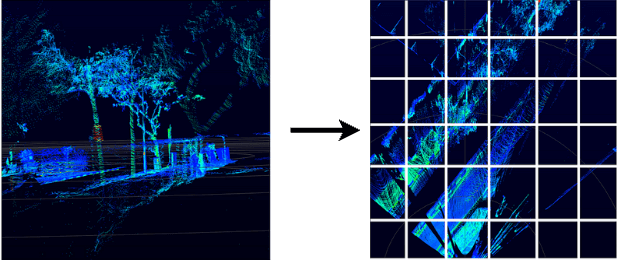

In this lab we will limit the input point cloud space to "limit_range = [–32, –32, –8, 32, 32, –3]", that is +/– 32 meters in x and y, and in z between –8 and –3 meters is of interest (this comes from an infrastructure lidar that seems to be at 8 meters hights).

We will also use "voxel_size = [0.64, 0.64, 5]", meaning that we squashed all z into one box, and have 100x100 in x an y, where (0,0) in grid space is bottom-left in the image.

For each BEV grid point we restrict ourself to T points (default=32), in total we then have T * (5 + 3 + 3) numbers for each grid point. Where the 11 elements are: the original point clouds (5), distance to the mean (3), offset to the pillar center(3).

In this implementation, the model will be basing a detection on the set of T points (11 element each) in a particular BEV grid point.


In [340]:
################################################################################
# Experiment Constants
# Define the input dimensions, and the BEV grid size
halfmaxlen = 32.0   # Input box size (in x & y) is set to +/– halfmaxlen [m]
zmax = -3.0         # Max value for z (negative due to the elevated sensor position)
zmin = -8.0         # Min value for z
zvoxsize = zmax - zmin # We only want 1 box hight in the z dimension
voxellen = 0.4      # Grid element size in input dimensions [m] org 0.64 
# With strides in the model, the feature space size will be reduced
# and we get faster computations (and less acuracy)
model_strides = [2,1] # Stride to reduce the feature space size, for each ResNet stack

limit_range = [-halfmaxlen, -halfmaxlen, zmin, halfmaxlen, halfmaxlen, zmax]
voxel_size = [voxellen, voxellen, zvoxsize]

# If we want the feature space be of same size as voxel space then
feature_len = int(halfmaxlen*2/voxellen)
# But now we actually use stride to reduce the size of the feature space
feature_len = int(feature_len/np.prod(model_strides)) # to compensate
features_shapes = [feature_len, feature_len]

#
maxppgrid = 32 # Max number of points per grid cell orginal 32

print(f'input limit range: {limit_range}')
print(f'voxel size: {voxel_size}')
print(f'features shape: {features_shapes}')


input limit range: [-32.0, -32.0, -8.0, 32.0, 32.0, -3.0]
voxel size: [0.4, 0.4, 5.0]
features shape: [80, 80]


##  Visualize a sample data to see what the dataset looks like.

<Axes: >

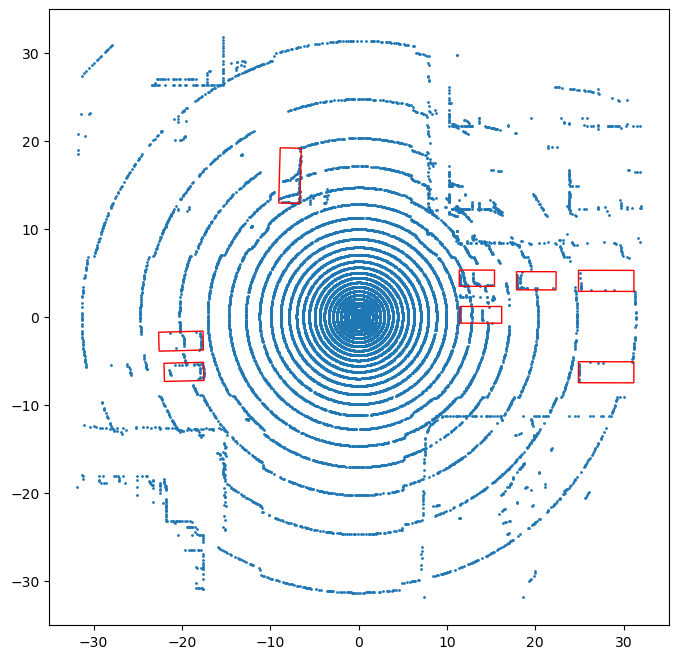

In [341]:
# Visualize the input point cloud and the labels (i.e. vehicles) that was anotated
dataset = LidarDetectionDataset(limit_range) # Get dataset
points, targets = dataset.fetch_single(100)  # Fetch a single scene (at index 100)
vis_point_cloud_2d(points,targets)
# print(points.shape)

In [342]:
# Code to calculate average number of points and targets per image
# in this dataset

##################### YOUR CODE STARTS HERE ###################

# need to grab both train and val datasets to get all images
dataset_val = LidarDetectionDataset(limit_range, train=False)
dataset_train = LidarDetectionDataset(limit_range, train=True)

# lets initialize some counters
total_points = 0
total_targets = 0
total_image = 0

# loop over both datasets and count points and targets per image
for dataset in [dataset_train, dataset_val]:
    num_samples = len(dataset)
    for i in range(num_samples):
        points, targets = dataset.fetch_single(i)
        total_points += points.shape[0]
        total_targets += targets.shape[0]
        total_image += 1

# calculate averages         
average_points = total_points/total_image
average_targets = total_targets/total_image
        
print(f'Average number of points per image: {average_points}')
print(f'Average number of targets per image: {average_targets}')
# just for verification that we have checked all images and do not miss any
print (f'Total number of images: {total_image}')

##################### YOUR CODE ENDS HERE #####################

Average number of points per image: 31191.87
Average number of targets per image: 11.99
Total number of images: 400


Average number of points per sample: 28722.4375
Average number of targets per sample: 11.675

Average number of points per sample: 31809.228125
Average number of targets per sample: 12.06875

STUDENT Questions:
* How many points are there in average per image for this dataset?
* How many targets are there in average per image for the this dataset?

YOUR Answers:
### For the hole dataset train + validation:
Average number of points per image: 31191.87
Average number of targets per image: 11.99

### For only train dataset:
Average number of points per image: 31809.228125
Average number of targets per image: 12.06875

### For only validation dataset:
Average number of points per image: 28722.4375
Average number of targets per image: 11.675




# Data Augmentation
Here we will use a random rotation (around the z-axis, i.e. [yaw](https://en.wikipedia.org/wiki/Yaw_(rotation))) as a data augmentation.

In [343]:
def rotate_aug(rot_range, ratio):
    """
    Creates a data augmentation function that randomly rotates point clouds and bounding boxes.
    Args:
        rot_range: A tuple (min_angle, max_angle) specifying the range of rotation angles in radians.
        ratio: The probability of applying the rotation augmentation.
    Returns:
        A function that takes point cloud points and bounding boxes as input and returns the rotated versions.
    """

    def global_rotation(points, gt_boxes):
        """
        Applies a global rotation to a point cloud and its bounding boxes
        Args:
            points: (M, 3 + C),
            gt_boxes: (N, 7 + C), [x, y, z, l, w, h, theta]
        Returns:
            A tuple containing the rotated point cloud and bounding boxes.
        """
        if random.random() > ratio:
            return points, gt_boxes

        noise_rotation = np.random.uniform(rot_range[0], rot_range[1])

        points = rotate_points_along_z(points[None, :, :],
                                                    np.array([noise_rotation]))[0]

        # rotate the center of gt_boxes
        gt_boxes_c = box_corner_to_center(gt_boxes)
        gt_boxes_c[:, 0:3] = \
            rotate_points_along_z(gt_boxes_c[None, :, 0:3],
                                            np.array([noise_rotation]))[0]
        gt_boxes_c[:, 6] += noise_rotation
        gt_boxes = box_center_to_corner(gt_boxes_c)
        return points, gt_boxes

    return global_rotation

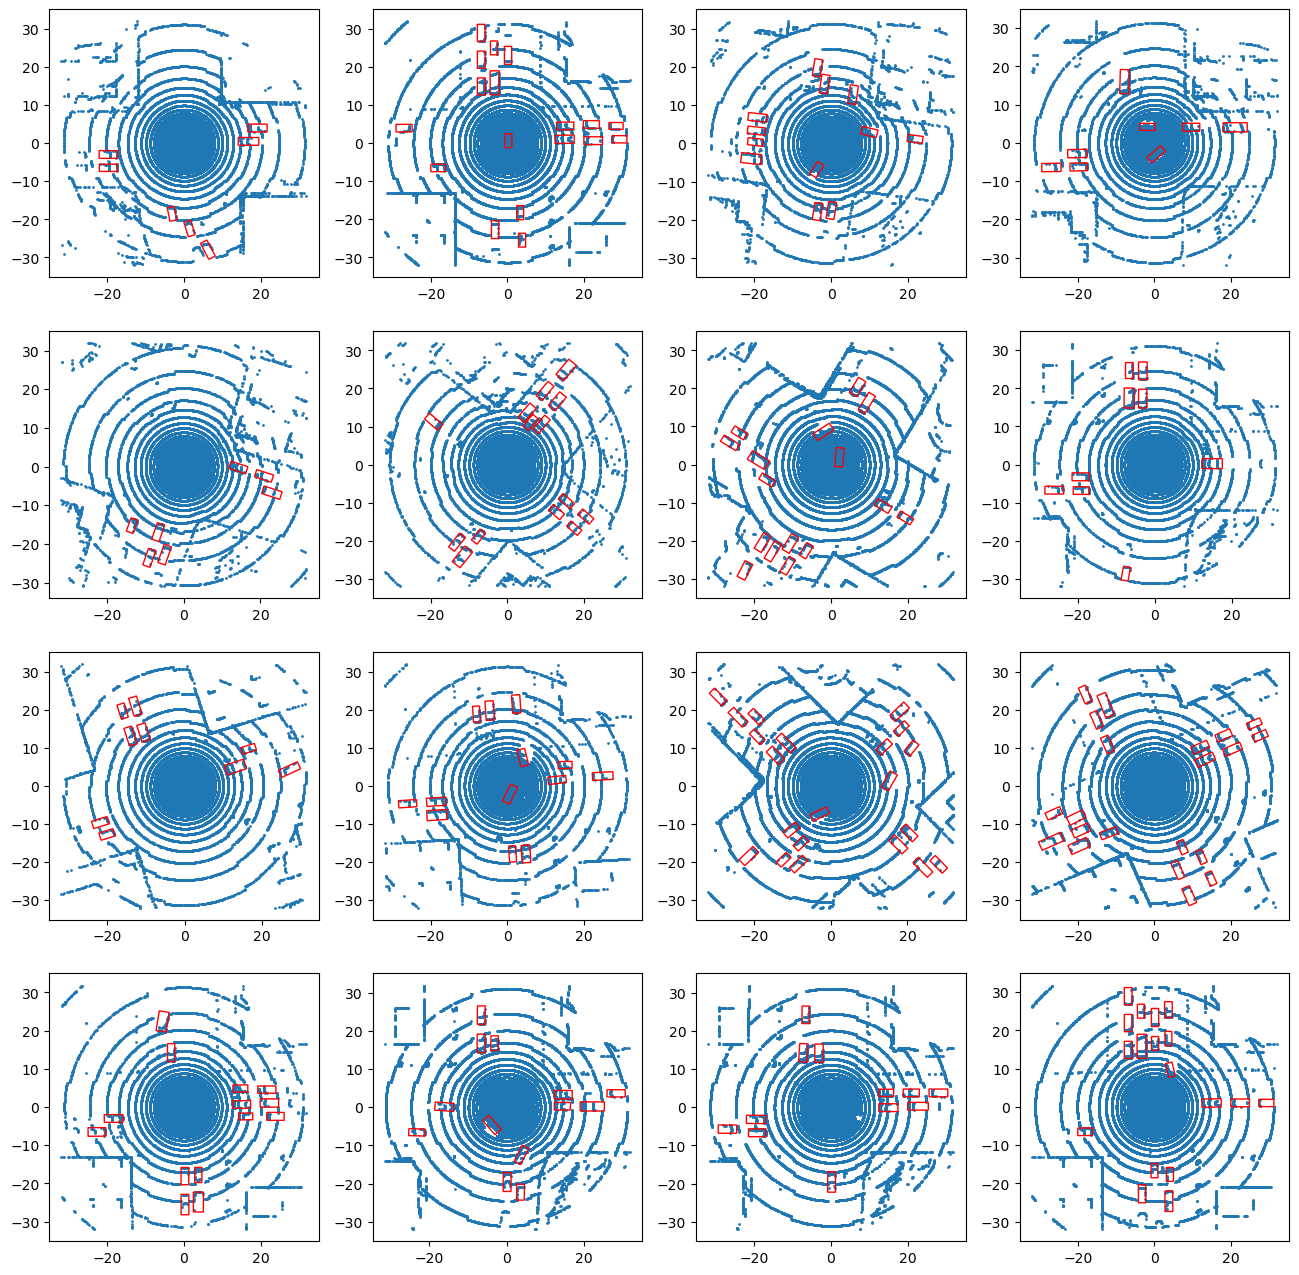

In [344]:
# Visualize the data augmentations (rotations)
agumentations = rotate_aug([math.radians(-90), math.radians(90)], 0.5)
dataset = LidarDetectionDataset(limit_range, transforms=agumentations)

import random
# Set up two subplots side-by-side to visualize all anchor boxes and the assigned ones
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
for i in range(4):
    for j in range(4):
        points, target = dataset.fetch_single(random.randint(0, len(dataset) - 1))
        axes[i][j].scatter(points[:, 0], points[:, 1], s=1)
        # Display all generated anchor boxes in the first subplot with red borders
        show_bboxes(axes[i][j], target, color='r')

STUDENT Questions:
* Please suggest an additional methods for data augmentation for this type of data.
* What are the things one need to think about (what can be tricky) when doing data augmentation for this type of data?

YOUR Answers:

# Generate anchor boxes
This is similar to laboratory 1, but we now represent the offset as (dx,dy,dz,r), where r is a rotation (around the z-axis).


In [345]:
# It's the same as 2D detector, in here we return the actuall size of the anchor boxes
def generate_anchor_boxes(features_shapes, limit_range, shapes=[(3.9, 1.6, 1.56, 0)]):
    """Generates anchor boxes for object detection.

    Args:
        features_shapes: Tuple of (height, width) of the BEV feature shape.
        limit_range: Tuple of (x_min, y_min, z_min, x_max, y_max, z_max) defining the 3D space.
        shapes: List of tuples (dx, dy, dz, r) representing anchor box dimensions.

    Returns:
        A 4D tensor of shape (height, width, num_anchors, 7) containing anchor boxes.
        Each anchor box is defined by [x, y, z, l, w, h, theta].
    """

    in_height, in_width = features_shapes
    n_anchor_boxes = len(shapes)

    vh = (limit_range[3] - limit_range[0]) / in_width # voxel_size
    vw = (limit_range[4] - limit_range[1]) / in_height

    x = np.linspace(limit_range[0] + vw/2, limit_range[3] - vw/2, in_width )
    y = np.linspace(limit_range[1] + vh/2, limit_range[4] - vh/2, in_height )


    center_x, center_y = np.meshgrid(x, y)
    center_z = (limit_range[2] + limit_range[5]) / 2
    centers_shift = np.concatenate(
        [center_x.reshape(-1, 1), center_y.reshape(-1, 1),
        center_z * np.ones_like(center_x).reshape(-1, 1)],
        axis=1
      ) # H*W, 3

    centers_shift = centers_shift[:, None, :].repeat( n_anchor_boxes, axis=1) # H*W, n_anchor_boxes, 3
    anchor_boxes = np.array(shapes)[None].repeat(in_height*in_width, axis=0) # number_anchor, 4 -->  H*W, n_anchor_boxes, 4

    anchor_boxes_all = np.concatenate([centers_shift, anchor_boxes], axis=2)
    return anchor_boxes_all.reshape((in_height, in_width, n_anchor_boxes, 7))

Anchor box shape: (80, 80, 2, 7), thus total number of anchor boxes: 12800



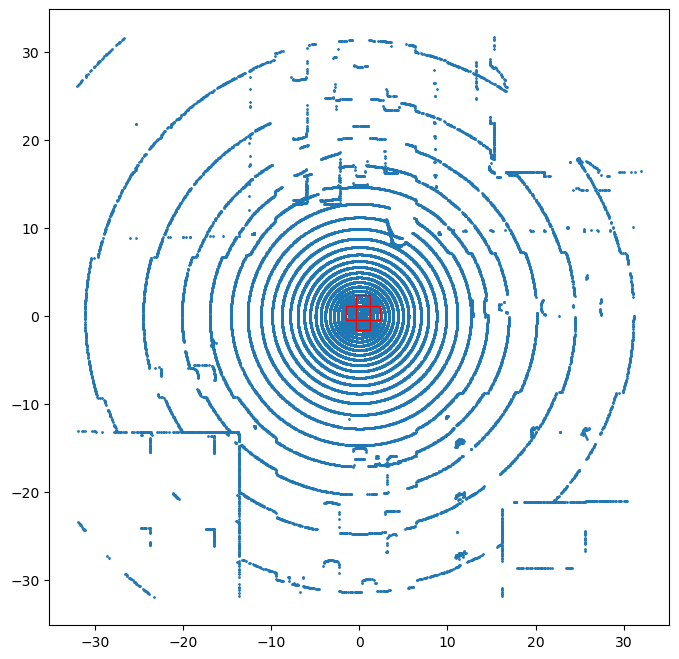

In [346]:
# Visualise the anchor generation
anchor_shapes = [(3.9, 1.6, 1.56, 0), (3.9, 1.6, 1.56, 90)]
anchor_shapes = [ (x[0], x[1], x[2], math.radians(x[3])) for x in anchor_shapes]

anchor_boxes = generate_anchor_boxes(features_shapes, limit_range, anchor_shapes) # in [x, y, z, h, w, l, yaw]
anchor_boxes_corner = box_center_to_corner(anchor_boxes[feature_len//2, feature_len//2, :])

vis_point_cloud_2d(points, anchor_boxes_corner, color='r')

print(f'Anchor box shape: {anchor_boxes.shape}, thus total number of anchor boxes: {np.prod(anchor_boxes.shape[:-1])}\n')

## Encode/decode the grounding truth boxes

Similar to lab 1, we need to calculate target box relative position and size compared to the anchor.

You can use the same encoding as lab 1 except we now have a new yaw angle (a rotation around the z-axis).


In [347]:
def encode_boxes(anchors, assigned_bb):
    """Encode the bounding boxes with respect to anchor boxes for training.
    Args:
        anchors (array): Anchor boxes, shape (N, 8, 3), defined by 4 corner coordinates.
        assigned_bb (array): Ground-truth bounding boxes assigned to each anchor, shape (N, 8, 3),
                                    with padding of zeros for unassigned anchors.
    Returns:
        array: Encoded bounding box offsets, shape (N, 7).
    """

    c_anchor = box_corner_to_center(anchors)
    c_assigned_bb = box_corner_to_center(assigned_bb)

    # Calculate relative offset for the center (x, y, z)
    offset_xyz = (c_assigned_bb[:, :3] - c_anchor[:, :3]) / c_anchor[:, 3:6]
    # Compute the logarithmic scale difference for dimensions (length, width, height)
    offset_lwh = np.log( 1e-8 + c_assigned_bb[:, 3:6] / c_anchor[:, 3:6])
    # Compute the difference in yaw angle, i.e. rotation around the z-axis
    offset_yaw = c_assigned_bb[:, 6:7] - c_anchor[:, 6:7]

    # Concatenate all offsets into a single array
    offset = np.concatenate([offset_xyz, offset_lwh, offset_yaw], axis=1)

    return offset  # Encoded offsets for bounding boxes relative to the anchors


def decode_boxes(c_anchors, offset_preds):
    """Decode the predicted offsets to actual bounding box coordinates.

    Args:
        anchors (array): Anchor boxes, shape (N, 7), defined by 4 corner coordinates.
        offset_preds (array): Predicted offsets for each anchor, shape (N, 7).

    Returns:
        array: Decoded bounding boxes in corner format, shape (N, 8, 3).
    """
    # Recover the predicted center (x, y, z) using the predicted offsets and anchors
    pred_bbox_xyz = (offset_preds[:, :3] * c_anchors[:, 3:6]) + c_anchors[:, :3]
    # Recover the predicted dimensions (length, width, height) using exponential scaling
    pred_bbox_lwh = np.exp(offset_preds[:, 3:6]) * c_anchors[:, 3:6]
    # Recover the predicted yaw angle, i.e. rotation around the z-axis
    pred_bbox_yaw = offset_preds[:, 6:7] + c_anchors[:, 6:7]
    # Combine the recovered parameters into a center-based representation
    pred_bbox = np.concatenate((pred_bbox_xyz, pred_bbox_lwh, pred_bbox_yaw), axis=1)
    predicted_bbox = box_center_to_corner(pred_bbox)
    return predicted_bbox

## Generate multi-box targets
This function is also similar to the one in Lab 1

In [348]:
def generate_multibox_target(anchors, labels):
    """ Generate a batch of target tuples,
    based on anchor boxes and a batch of ground-truth labels (ground-truth bounding boxes and class labels).
    Args:
        anchors (array): array containing anchor boxes.
        labels (array): array of ground-truth labels (a batch), with GT class and GT bounding box coordinates.
    Returns:
        tuple: (bbox_offset, bbox_mask, class_labels) where:
            - bbox_offset: Encoded offsets for each anchor relative to assigned ground-truth boxes.
            - bbox_mask: Mask to indicate valid anchor assignments for loss calculation.
            - class_labels: Class labels for each anchor, with 0 as the background class.
    """

    # Determine batch size and reshape anchors for use in batch operations
    batch_size = len(labels)

    # Initialize lists to store the target offsets, masks, and class labels for each batch
    batch_offset, batch_mask, batch_class_labels = [], [], []

    num_anchors = anchors.shape[0]

    for i in range(batch_size):
        # Extract the labels for the i-th image, containing classes and bounding box coordinates
        label = labels[i]

        # Map each anchor to the closest ground-truth box, using IoU thresholding
        anchors_bbox_map = assign_anchor_to_bbox(corner_to_bounding2d(label), corner_to_bounding2d(anchors)) # n_anchor_boxes

        # Create a mask for assigned anchors: 1 if assigned, 0 otherwise
        # bbox_mask = (anchors_bbox_map >= 0).astype(np.float32)[:,None].repeat(4, axis=1)
        bbox_mask = (anchors_bbox_map >= 0).astype(np.float32)

        # Initialize class labels and bounding box assignments to zero (background class)
        class_labels = np.zeros(num_anchors, dtype=np.int32)
        assigned_bb = np.zeros((num_anchors, 8, 3), dtype=np.float32)

        # Find indices of anchors assigned to ground-truth boxes
        indices_true = np.where(anchors_bbox_map >= 0)

        # Retrieve indices of assigned ground-truth boxes for these anchors
        bb_idx = anchors_bbox_map[indices_true]

        # Set class labels for assigned anchors based on ground-truth box classes
        # Label 0 is for background; other values correspond to object classes
        class_labels[indices_true] = 1 # only one class in this situation

        # Assign the corresponding ground-truth box coordinates to these anchors
        assigned_bb[indices_true] = label[bb_idx]

        # Apply an encoding transformation to get offsets between anchors and assigned boxes
        # Offsets are masked with bbox_mask to ignore non-assigned anchors in loss calculations
        offset = encode_boxes(anchors, assigned_bb) * bbox_mask[:,None].repeat(7, axis=1)

        batch_offset.append(offset)
        batch_mask.append(bbox_mask)
        batch_class_labels.append(class_labels)

    # Stack results for each batch to return as tensors
    bbox_offset = np.stack(batch_offset)  # Encoded offsets for each anchor
    bbox_mask = np.stack(batch_mask)      # Mask to indicate assigned anchors
    class_labels = np.stack(batch_class_labels)  # Class labels for each anchor

    return (bbox_offset, bbox_mask, class_labels)

# The voxelization of 3D points

Voxelization is the process to convert the sparse and unstructured 3D point cloud into a structured grid (BEV representation).

Process:
* Splits the 3D space into a grid of voxels.
* Aggregates features (e.g., density, height, intensity) from the points within each voxel.

Output: A structured 2D feature map representing the BEV.

In [349]:
def voxelize_pyorg(pcd_np, voxel_size, limit_range, T=32):
    """
    Preprocesses LiDAR point cloud data by voxelization.
    Parameters:
        pcd_np (np.ndarray): The raw LiDAR point cloud data (N x 3 or N x C, where C includes additional features).
        voxel_size (tuple): The size of each voxel along (x, y, z) axes.
        limit_range (tuple): The spatial limits for voxelization [x_min, y_min, z_min, x_max, y_max, z_max].
        T (int): Maximum number of points per voxel (default: 32).
    Returns:
        np.ndarray: Voxelized point cloud data in a structured grid (shape: H x W x T x 8).
    """
    # Calculate the number of voxels along each axis
    feature_dx = np.ceil((limit_range[3] - limit_range[0]) / voxel_size[0]).astype(np.int32)
    feature_dy = np.ceil((limit_range[4] - limit_range[1]) / voxel_size[1]).astype(np.int32)
    feature_dz = np.ceil((limit_range[5] - limit_range[2]) / voxel_size[2]).astype(np.int32)
    # Ensure the z-axis voxel count is limited to 1 (e.g., for a 2D grid representation)
    assert feature_dz == 1

    voxel_size = np.array(voxel_size)
    # Normalize point coordinates to voxel indices
    voxel_coords = (pcd_np[:, :3] - np.array([limit_range[0], limit_range[1], limit_range[2]])) / voxel_size
    voxel_coords = np.floor(voxel_coords).astype(np.int32)

    # Sort points based on voxel coordinates to efficiently group points within the same voxel
    sort_idx = np.lexsort((voxel_coords[:, 2], voxel_coords[:, 1], voxel_coords[:, 0]))
    voxel_coords = voxel_coords[sort_idx]
    pcd_np = pcd_np[sort_idx]

    # Find indices where voxel coordinates change, indicating the start of a new voxel
    diff_indices = np.where(np.any(np.diff(voxel_coords, axis=0), axis=1))[0] + 1
    voxel_start_indices = np.concatenate(([0], diff_indices))
    voxel_end_indices = np.concatenate((diff_indices, [len(voxel_coords)]))

    # Initialize the voxel feature grid (H x W x T x 11)
    voxel_features = np.zeros((feature_dy, feature_dx, T, 11), dtype=np.float32)

    # Vectorized computation of voxel features
    for i in range(len(voxel_start_indices)):
        start = voxel_start_indices[i]
        end = voxel_end_indices[i]
        pts = pcd_np[start:end]
        num_points = min(pts.shape[0], T)

        # Calculate relative positions efficiently
        f_cluster = pts[:, :3] - np.mean(pts[:, :3], axis=0)
        f_center = pts[:, :3] - (voxel_coords[start, :] * voxel_size + limit_range[:3] + voxel_size / 2)

        # Populate voxel features using slicing and concatenation
        voxel = np.zeros((T, 11), dtype=np.float32)
        voxel[:num_points, :3] = pts[:num_points, :3]
        voxel[:num_points, 3:6] = f_cluster[:num_points, :]
        voxel[:num_points, 6:9] = f_center[:num_points, :]
        voxel_features[voxel_coords[start, 1], voxel_coords[start, 0], :num_points, :] = voxel[:num_points, :]

    return voxel_features

In [350]:
from numba import njit
from typing import Tuple
@njit # alias for @jit(nopython=True)
def voxelize_jit(
        points: np.ndarray,
        voxel_size: np.ndarray,
        grid_range: np.ndarray,
        max_points_in_voxel: int = 60,
        max_num_voxels: int = 20000
)-> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Numba-friendly version of voxelize
    :param points: (num_points, num_features), first 3 elements must be <x>, <y>, <z>
    :param voxel_size: (3,) - <width>, <length>, <height>
    :param grid_range: (6,) - <min_x>, <min_y>, <min_z>, <max_x>, <max_y>, <max_z>
    :param max_points_in_voxel:
    :param max_num_voxels:
    :return: tuple (
        voxels (num_voxels, max_points_in_voxels, num_features),
        coordinates (num_voxels, 3),
        num_points_per_voxel (num_voxels,)
    )
    """
    points_copy = points.copy()
    grid_size = np.floor((grid_range[3:] - grid_range[:3]) / voxel_size).astype(np.int32)

    coor_to_voxelidx = np.full((grid_size[2], grid_size[1], grid_size[0]), -1, dtype=np.int32)
    voxels = np.zeros((max_num_voxels, max_points_in_voxel, points_copy.shape[-1]), dtype=points_copy.dtype)
    coors = np.zeros((max_num_voxels, 3), dtype=np.int32)
    num_points_per_voxel = np.zeros(shape=(max_num_voxels,), dtype=np.int32)

    coor = np.floor((points_copy[:, :3] - grid_range[:3]) / voxel_size).astype(np.int32)
    mask = np.logical_and(np.logical_and((coor[:, 0] >= 0) & (coor[:, 0] < grid_size[0]),
                                         (coor[:, 1] >= 0) & (coor[:, 1] < grid_size[1])),
                          (coor[:, 2] >= 0) & (coor[:, 2] < grid_size[2]))
    coor = coor[mask, ::-1]
    points_copy = points_copy[mask]
    assert points_copy.shape[0] == coor.shape[0]

    voxel_num = 0
    for i, c in enumerate(coor):
        voxel_id = coor_to_voxelidx[c[0], c[1], c[2]]
        if voxel_id == -1:
            voxel_id = voxel_num
            if voxel_num > max_num_voxels:
                continue
            voxel_num += 1
            coor_to_voxelidx[c[0], c[1], c[2]] = voxel_id
            coors[voxel_id] = c
        n_pts = num_points_per_voxel[voxel_id]
        if n_pts < max_points_in_voxel:
            voxels[voxel_id, n_pts] = points_copy[i]
            num_points_per_voxel[voxel_id] += 1

    return voxels[:voxel_num], coors[:voxel_num], num_points_per_voxel[:voxel_num]

def voxelize(pcd_np, voxel_size, limit_range, T=32):

    feature_dx = np.ceil((limit_range[3] - limit_range[0]) / voxel_size[0]).astype(np.int32) #feature_dx: 100
    feature_dy = np.ceil((limit_range[4] - limit_range[1]) / voxel_size[1]).astype(np.int32) #feature_dy: 100 
    feature_dz = np.ceil((limit_range[5] - limit_range[2]) / voxel_size[2]).astype(np.int32) #feature_dz: 1
    # Ensure the z-axis voxel count is limited to 1 (e.g., for a 2D grid representation)
    assert feature_dz == 1
    voxel_size = np.array(voxel_size)
    voxels_np, coords_th, num_points_per_voxel = voxelize_jit(pcd_np, voxel_size, np.array(limit_range), T, 5000)
    

    # --- FIX 2025-12-15 STARTS HERE ---
    # Calculate sum of points per voxel
    voxel_sums = np.sum(voxels_np[:, :, :3], axis=1)
    
    # Avoid division by zero
    num_points_clamped = num_points_per_voxel.copy().astype(np.float32)
    num_points_clamped[num_points_clamped == 0] = 1.0

    # Compute true mean (centroid)
    voxel_means = voxel_sums / num_points_clamped[:, None]

    # Compute f_cluster correctly
    # We need to mask the zero-padded points so they remain 0, or just let subtraction happen
    # (since 0 - mean is technically valid as a feature, but masking is cleaner)
    f_cluster = voxels_np[:, :, :3] - voxel_means[:, None, :]

    coords_np = coords_th[:, [2, 1, 0]] # dz, dy, dx -> dx, dy, dz
    # f_cluster =  voxels_np[:, :, :3] - np.mean(voxels_np[:, :, :3], axis=1, keepdims=True) # incorrect
    # --- FIX 2025-12-15 ENDS HERE ---


    f_center = voxels_np[:, :, :3] - (coords_np * voxel_size + limit_range[:3] + voxel_size/2)[:, None,:]
    pillar_features = np.concatenate([voxels_np, f_cluster, f_center], axis=-1)
    # scatter it back
    voxel_features = np.zeros((feature_dy, feature_dx, T, 11))
    voxel_features[coords_np[:, 1], coords_np[:, 0]] = pillar_features
    
    
    ## Doing some investigation  / Rickard Sörlin
    
    #print(f'feature_dx: {feature_dx}, feature_dy: {feature_dy}')  #feature_dx: 100, feature_dy: 100 
    #print(f'feature_dz: {feature_dz}')                            #feature_dz: 1
    #print(f'voxel_features shape: {voxel_features.shape}')        # voxel_features shape: (100, 100, 32, 11)
  
    #print("voxels_np shape:", voxels_np.shape)       # (num_voxels, T, 5)
    #print("f_cluster shape:", f_cluster.shape)       # (num_voxels, T, 3)
    #print("f_center shape:", f_center.shape)         # (num_voxels, T, 3)
    
    #print(f'Pillar features shape: {pillar_features.shape}')      # Pillar features shape: (num_voxels, 32, 11)
    

    return voxel_features

STUDENT Question:
* Why are we restricting the maximum number of points per voxel (maxppgrid)?
* What would be a resonable maximum number, motivate?

YOUR Answer:

According to Fernades et. al in there report "Point-Cloud based 3D Object Detection and Classification Methods for Self-Driving Applications: A Survey and Taxonomy"
The restriction of maximum number of point per voxel in this case is 32, is to reduce the precessing time and reduce the imbalance of points between voxels and aswell reduce the sampling bias and add more variation during training.

According to same report Fernades et. al maximum number of points per voxel is set to 100 in the research projects VoxelNet, Second and PointPillars sow based on that 100 
looks to be a good limit.

# Now set up the Trainingset Class based on Achor Points

In [351]:
# Class to create a LidarDetectionDataset with MultiboxTarget
class LidarDetectionDatasetWithMultiboxTarget(LidarDetectionDataset):
    """
    A subclass of `LidarDetectionDataset` with added functionality for:
        - Generating anchor boxes
        - Assigning ground truth bounding boxes and class labels to anchors using multibox target
    """
    def __init__(self, voxel_size, anchor_shapes, limit_range, batch_size=1, transforms=None, train = True, **kwargs):
        """
        Initializes the dataset with additional multibox target features.

        Parameters:
            voxel_size (tuple): Size of each voxel along (x, y, z) axes.
            anchor_shapes (list): Predefined shapes for anchor boxes.
            limit_range (list): Spatial limits for voxelization [x_min, y_min, z_min, x_max, y_max, z_max].
            batch_size (int): Number of samples per batch.
            transforms (callable): Optional transform to be applied on a sample.
            train (bool): Flag indicating whether the dataset is for training or validation.
            **kwargs: Additional arguments passed to the parent class.
        """
        super().__init__(limit_range, batch_size, transforms, train, **kwargs)
        # Generate 3D anchor boxes and their corner representations

        features_shapes = np.array([limit_range[3] - limit_range[0], limit_range[4] - limit_range[1]]) / (voxel_size[0], voxel_size[1]) / np.prod(model_strides)
        features_shapes = np.floor(features_shapes).astype(np.int32)

        self.anchors = generate_anchor_boxes( features_shapes, limit_range, anchor_shapes).reshape(-1, 7)
        self.anchors_corners = box_center_to_corner(self.anchors)
        self.voxel_size = voxel_size # Store voxel size for later use in voxelization

    def __getitem__(self, index):
        """
        Fetches a batch of data and processes it to include voxel features and multibox targets.
        Parameters:
            index (int): Batch index.
        Returns:
            tuple:
                - voxel_features (ndarray): Voxelized representation of point clouds (shape: BxHxWxTx8).
                - targets (ndarray): Encoded bounding boxes and class labels for each anchor (shape: BxNx8).
        """
        # Get point clouds and ground truth bounding boxes from the parent class
        point_l, target_l = super().__getitem__(index)
        # Preprocess point clouds by voxelizing them
        voxel_features = [ voxelize(points, self.voxel_size, self.limit_range, maxppgrid)[None] for points in point_l ]
        voxel_features = np.concatenate(voxel_features, axis=0) # b, h, w, T, 8

        # Generate multibox targets (bounding box labels, masks, and class labels) for the anchors
        bbox_labels, bbox_masks, cls_labels = generate_multibox_target(self.anchors_corners, target_l)
        # Ensure compatibility with Keras 3 by zeroing class labels where bounding box mask is invalid
        cls_labels[bbox_masks < 1] = 0
        # Concatenate bounding box labels and class labels into one tensor for the model
        return voxel_features, np.concatenate( (bbox_labels, cls_labels[:, :, None]), axis=-1)

# Build a detection model

Our detection model will consists of the following parts:
* Voxel Feature Encoding - that converts the training data input tensor to a tensor input for the backbone (b, h, w, 32), using a Dense layer
* Backbone -  We will build a custom backbone, from stacks of ResNet residual blocks. (3 blocks with 32 filters plus 3 blocks with 48 filters)
* This the feeds into two output blocks:
    * Classification: A classification for each anchor, at each grid point (1x1 kernel)
    * Bounding Box Regression: A bounding box offset for each anchor

Note that we are training the whole network from scratch (thus we are not using transfer learning in this case)!

In [352]:
################################################################################
# Parameters for the Detection Model
input_map_size = 32         # size of first hidden layer after input 32
resnet_layer_sizes = [32,48] # layer size of the resnet stacks

# Import a function that defines A set of stacked residual blocks.
# Code in https://fossies.org/linux/keras/keras/src/applications/resnet.py
from keras.src.applications.resnet import stack_residual_blocks_v1

class Detector(keras.Model):
    def __init__(self, num_anchors, num_classes, **kwargs):
        """Initialize the Detector model with base model, feature extractors, and anchor box predictors.
        Args:
            num_anchors (int): Number of anchor boxes per feature map location.
            num_classes (int): Number of object classes to predict.
        """
        super(Detector, self).__init__(**kwargs)

        """Builds a custom Resnet model"""
        def create_backbone():
            backbone_inputs = layers.Input(shape=(None, None, input_map_size))
            x = stack_residual_blocks_v1(backbone_inputs, resnet_layer_sizes[0], 3, stride1=model_strides[0], name="conv1")
            x = stack_residual_blocks_v1(x, resnet_layer_sizes[1], 3, stride1=model_strides[1], name="conv2")
            # x = stack_residual_blocks_v1(x, resnet_layer_sizes[2], 3, stride1=1, name="conv3")
            model = keras.Model(backbone_inputs, x, name="backbone")
            return model

        self.vfe_linear = keras.layers.Dense(input_map_size, name="vfe_linear") # Voxel Feature Encoding
        self.vfe_linear2 = keras.layers.Dense(input_map_size, name="vfe_linear2") 
        
        self.backbone = create_backbone()
        self.num_classes = num_classes
        self.cls_predictor = layers.Conv2D(num_anchors * (num_classes + 1), 1, 1, name="cls")
        # We use 7 numbers to represent a 3D box: (x, y, z, dx, dy, dz, yaw).
        self.bbox_predictor = layers.Conv2D(num_anchors * 7, 1, 1, name="bbox")

    def call(self, x):
        """Forward pass through the model to extract features, generate anchor boxes, and make predictions.
        Args:
            x (tensor): Input tensor with shape (b, h, w, T, 11)
                        The 11 = x,y,z,intesity,color (5 from original point) +
                        distance to the mean (3) + offset to the pillar center (3).
        Returns:
            tehnsor: Output tensor with shape (b, h*w*num_anchors, (num_classes + 1) + 7)
        """
        x = self.vfe_linear(x) # b, h, w, T, 11 -> b, h, w, T, input_map_size
        """
        b = ops.shape(x)[0] 
        h = ops.shape(x)[1] 
        w = ops.shape(x)[2] 
        T = ops.shape(x)[3]
        C = ops.shape(x)[4]

        # Flatten the T and C dimensions into one per voxel 
        x = ops.reshape(x, (b, h, w, T * C)) # (b, h, w, T * input_map_size)
        # Adding trainable layer voxel wise aggregation instead of max pooling
        x = self.vfe_linear2(x)  #  (b, h, w, input_map_size)
        
        """
        
        x = ops.max(x, axis=3, keepdims=False) #  b, h, w, input_map_size
        
        features = self.backbone(x)
        cls_preds = self.cls_predictor(features)
        bbox_preds = self.bbox_predictor(features)

        # for better keras 3 support, concatnate into one tensor
        b = ops.shape(features)[0]
        cls_preds = ops.reshape(cls_preds, (b, -1, self.num_classes + 1)) # b, h, w, num_anchors * (num_classes + 1) --> b, h*w*num_anchors, (num_classes + 1)
        bbox_preds = ops.reshape(bbox_preds, (b, -1, 7)) # b, h, w, num_anchors * 7 --> b, h*w*num_anchors, 7

        return ops.concatenate( (bbox_preds, cls_preds), axis=-1)

# Create a test detector, to check shapes
# detector = Detector(num_anchors=2, num_classes=1)
# out = detector(np.random.rand(1, feature_len, feature_len, 32, 11))
# print(f'Detector output shape: {out.shape}')

In [353]:
# Print the backbone structure
def create_backbone():
    backbone_inputs = layers.Input(shape=(None, None, input_map_size))
    x = stack_residual_blocks_v1(backbone_inputs, resnet_layer_sizes[0], 3, stride1=model_strides[0], name="conv1")
    x = stack_residual_blocks_v1(x, resnet_layer_sizes[1], 3, stride1=model_strides[1], name="conv2")
    # x = stack_residual_blocks_v1(x, resnet_layer_sizes[2], 3, stride1=1, name="conv3")
    model = keras.Model(backbone_inputs, x, name="backbone")
    return model

bb_model = create_backbone()
bb_model.summary()

Model: "backbone"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_block1_1_conv │ (None, None,      │      1,056 │ input_layer_20[0… │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_block1_1_bn   │ (None, None,      │        128 │ conv1_block1_1_c… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_block1_1_relu │ (None, None,      │          0 │ conv1_block1_1_b… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_block1_2_conv │ (None, None,      │      9,248 │ conv1_block1_1_r… │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_block1_2_bn   │ (None, None,      │        128 │ conv1_block1_2_c… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_block1_2_relu │ (None, None,      │          0 │ conv1_block1_2_b… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_block1_0_conv │ (None, None,      │      4,224 │ input_layer_20[0… │
│ (Conv2D)            │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_block1_3_conv │ (None, None,      │      4,224 │ conv1_block1_2_r… │
│ (Conv2D)            │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_block1_0_bn   │ (None, None,      │        512 │ conv1_block1_0_c… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_block1_3_bn   │ (None, None,      │        512 │ conv1_block1_3_c… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_block1_add    │ (None, None,      │          0 │ conv1_block1_0_b… │
│ (Add)               │ None, 128)        │            │ conv1_block1_3_b… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_block1_out    │ (None, None,      │          0 │ conv1_block1_add… │
│ (Activation)        │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_block2_1_conv │ (None, None,      │      4,128 │ conv1_block1_out… │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_block2_1_bn   │ (None, None,      │        128 │ conv1_block2_1_c… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_block2_1_relu │ (None, None,      │          0 │ conv1_block2_1_b… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_block2_2_conv │ (None, None,      │      9,248 │ conv1_block2_1_r

 Total params: 201,056 (785.38 KB)

 Trainable params: 197,536 (771.62 KB)

 Non-trainable params: 3,520 (13.75 KB)

In [354]:
# Instatiate the training and validation datasets
batch_size = 4
agumentations = rotate_aug([-1.57, 1.57], 0.5)

dataset_train = LidarDetectionDatasetWithMultiboxTarget(voxel_size, anchor_shapes, limit_range, batch_size, transforms=agumentations,
                                                        train=True, workers=1, use_multiprocessing=False, max_queue_size=24)
dataset_val = LidarDetectionDatasetWithMultiboxTarget(voxel_size, anchor_shapes, limit_range, batch_size, transforms=None,
                                                        train=False, workers=1, use_multiprocessing=False, max_queue_size=24)

In [355]:
# Look at the shape of the training dataset
ex_points, ex_labels = dataset_train.__getitem__(0) # get a batch of data
print(f'Training dataset input shape: {ex_points.shape}') # (4, 160, 160, 32, 11)
print(f'Training dataset label shape: {ex_labels.shape}') # (4, 12800, 8)

Training dataset input shape: (4, 160, 160, 32, 11)
Training dataset label shape: (4, 12800, 8)


STUDENT Question:
* For each of the values in the input and label shape, explain what the values are coming from (like: the 4 is the batch size)

YOUR Answer:

Training dataset input shape: (4, 100, 100, 32, 11)

 4: This is the batch size, the number of Lidar samples in each batch.   
 
 100,100: These comes frome the voxelize() function via feature_dx and feature_dy. They represents the number of voxels (grid cells) in x and y in the BEV plane.
 The defined range -32m,32m with voxel size 0.64 m gives 64/0,64 = 100 cells in each direction.

 32: This is the maximum number of Lidar points per voxel, defined by maxppgrid = 32. When we voxelize, we keep at most 32 Lidar point in each voxel, if we have more we will discard above, if we have less we will zero-padd.
 
 11: This comes from the voxelize() function and pillar_features tensor. It is the number of features per point, created by concatenating (voxel_np) the 5 orginal point features x,y,z,intensity,color with 3 offsets from the voxel_mean (f_cluser) and the 3 offsets from the voxel center (f_center).   

Training dataset label shape: (4, 5000, 8)

 4: This is the batch size, the number of Lidar samples in each batch  

 5000: This is the maximum number of anchors/voxels per image that we assign labels to. 
 The value max_num_voxels=5000 is defined as limit when calling function voxelize_jit inside the function voxelize()

 8: This is the number of values per anchor, encoding the ground truth information for that anchor, such as bounding box parameters, orientation and class label.

In [356]:
# Define the loss function
num_classes = 1

class DetectorLoss():
    """
    A custom loss function for a 3D object detector.
    Combines classification loss (for object presence) and regression loss (for bounding box accuracy).
    """
    def __init__(self, num_classes):
        """
        Initializes the loss components and parameters.
        Parameters:
            num_classes (int): Number of object classes (default: 1 for binary classification).
        """
        # Classification loss: Sparse Categorical Crossentropy
        # - Used to classify whether anchors contain objects or not
        self.cls_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=None)
        # Bounding box regression loss: Mean Absolute Error (L1 loss)
        # - Measures the absolute difference between predicted and ground truth box parameters
        self.bbox_loss = keras.losses.MeanAbsoluteError(reduction=None)
        self.num_classes = num_classes # Number of object classes
        # Class balancing weights: Assign more weight to positive samples
        # - Background (class 0) is weighted lower (0.1) than objects (class 1) (1)
        self.balance_weights = [0.1, 1]

    @staticmethod
    def add_sin_difference(boxes1, boxes2):
        """Convert the rotation difference to difference in sine function.
        Args:
            boxes1 (tensor): Original Boxes in shape (NxC), where C>=7
                and the 7th dimension is rotation dimension.
            boxes2 (tensor): Target boxes in shape (NxC), where C>=7 and
                the 7th dimension is rotation dimension.
        Returns:
            tuple[tensor]: ``boxes1`` and ``boxes2`` whose 7th
                dimensions are changed.
        """
        rad_pred_encoding = ops.sin(boxes1[..., 6:7]) * ops.cos(
            boxes2[..., 6:7])
        rad_tg_encoding = ops.cos(boxes1[..., 6:7]) * ops.sin(boxes2[...,
                                                                         6:7])
        boxes1 = ops.concatenate(
            [boxes1[..., :6], rad_pred_encoding, boxes1[..., 7:]], axis=-1)
        boxes2 = ops.concatenate([boxes2[..., :6], rad_tg_encoding, boxes2[..., 7:]], axis=-1)
        return boxes1, boxes2

    def __call__(self, y_true, y_pred):
        """
        Computes the combined loss for a batch of predictions.
        Parameters:
            y_true (tensor): Ground truth labels (shape: BxNx8, where 8 includes bounding box + class).
            y_pred (tensor): Model predictions (shape: BxNx8).
        Returns:
            tensor: Total loss value (classification + regression).
        """

        boxes_gt = y_true[:, :, :7] # Ground truth bounding boxes (first 7 parameters)
        cls_gt = y_true[:, :, 7] # Ground truth class labels (last parameter)
        boxes_pred = y_pred[:, :, :7] # Predicted bounding boxes (first 7 parameters)
        cls_pred = y_pred[:, :, 7:] # Predicted class probabilities (last parameter, logits for classification)

        boxes_gt, boxes_pred = self.add_sin_difference(boxes_gt, boxes_pred)

        b = ops.shape(y_true)[0] # Batch size (B)

        # Classification loss
        # weighted and summed over the batch / batchsize
        cls_l = self.cls_loss(cls_gt, cls_pred) # Classification loss
        weights_per_sample = ops.where(cls_gt < 1, self.balance_weights[0], self.balance_weights[1]) # Assign balancing weights
        cls_l = ops.divide(ops.sum(cls_l * weights_per_sample), b) # Sum over batch

        # Calculate bounding box regression loss
        # applying the mask to ignore non-assigned boxes, summed over the batch / batchsize
        bbox_l = self.bbox_loss(boxes_gt, boxes_pred)
        bbox_l = ops.where(cls_gt < 1, 0., bbox_l)
        bbox_l = ops.divide(ops.sum(bbox_l), b)
        return cls_l + bbox_l

In [357]:
learning_rate = 1e-3
optimizer = keras.optimizers.Adam(learning_rate) # 1e-3
detector_loss = DetectorLoss(num_classes)

# Set up our detector model
model = Detector(
    num_anchors=len(anchor_shapes),
    num_classes=num_classes
)

# Compile the model
model.compile(loss=detector_loss, optimizer=optimizer)

STUDENT Questions:
* How many trainable parameters is in the model?

(This is not trivial to get from the model as model.summary do not give the correct answer. Do not get stuck on this for to long, return later to this question when the rest is done. Or maybe try to figure this out while you are waiting on your training?)

In [358]:
model.summary()

Model: "detector_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vfe_linear (Dense)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vfe_linear2 (Dense)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ backbone (Functional)           │ ?                      │       201,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cls (Conv2D)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bbox (Conv2D)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 201,056 (785.38 KB)

 Trainable params: 197,536 (771.62 KB)

 Non-trainable params: 3,520 (13.75 KB)

Total number of trainable parameters: 201394

YOUR Answers: At first before training the model.summary() didnt show correct count of trainable parameters it only counted the backbone parameter: 197,536 
Becuase the Dense, Conv head weights wasnt created at the time when it hasnt seen the input, after training those layers got built where total number of trainable was counted to: 201394

197,536(Backbone) + 384 (vfe_linear)  + 772 (cls) + 2702 (bbox) = 201394


Total params: 607,704 (2.32 MB)

Trainable params: 201,394 (786.70 KB)

Non-trainable params: 3,520 (13.75 KB)

Optimizer params: 402,790 (1.54 MB)


# Do the model training

A pretrained model is available: https://drive.google.com/file/d/1b5u8vdGKvuokTYyDwhRplS35nUBMunaE/view?usp=sharing

In [ ]:
num_epochs = 50  # Number of times the model will see the entire dataset (running on a T4, you can change that to e.g. 10)

# Define early stopping
es = keras.callbacks.EarlyStopping('val_loss', patience=3, restore_best_weights = True)

# Do the actual trainings
start = time.perf_counter()
# %prun -s cumulative time history = model.fit(dataset_train, epochs=num_epochs, callbacks = [es], validation_data=dataset_val)
history=model.fit(dataset_train, epochs=num_epochs, callbacks = [es], validation_data=dataset_val)
end = time.perf_counter()
print(f"Time to run: {end - start:.2f}",)

Epoch 1/50


/opt/anaconda3/envs/Teensorflow_Autonomasystem/lib/python3.11/site-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'detector_10', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 67s 574ms/step - loss: 244.1085 - val_loss: 85.3558
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 46s 550ms/step - loss: 79.9175 - val_loss: 66.6978
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 42s 512ms/step - loss: 67.0331 - val_loss: 59.6002
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 41s 490ms/step - loss: 56.9301 - val_loss: 55.2541
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 39s 466ms/step - loss: 54.1856 - val_loss: 44.0574
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 41s 498ms/step - loss: 46.7931 - val_loss: 43.9372
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 39s 469ms/step - loss: 42.0366 - val_loss: 46.7196
Epoch 8/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 41s 500ms/step - loss: 41.8883 - val_loss: 41.9277
Epoch 9/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 40s 484ms/step - loss: 39.7524 - val_loss: 40.9167
Epoch 10/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 453ms/step - loss: 39.4856 - val_loss: 37.8651
Epoch 11/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 37s 449ms/step - loss: 37.9225 - val_loss: 38.5612
Epoch 12/50
80/80 ━━━━━━━━━━━

In [ ]:
# Running-time experiments, to find bottlenecks
# Time to run:   64.90 for 5 epochs with original code (3090)
# Time to run:  500.96 for 5 epochs with original code (T4)
# Time to run:  391.55 for 5 epochs with original code (T4, workers=1, use_multiprocessing=False)
# Time to run:  617.67 for 5 epochs with original code (T4, workers=4, use_multiprocessing=False)
# Time to run:  220.86 for 5 epochs with new jit voxilization code (T4, workers=1, use_multiprocessing=False)
# Time to run:   77.28 for 5 epochs with new jit voxilization code (3090, workers=1, use_multiprocessing=False)

# 2025
# Time to run:  465.17 for 15 epochs with new jit voxilization code (T4, workers=1, use_multiprocessing=False)
# Time to run:  123.69 for 15 epochs with new jit voxilization code (4090, workers=1, use_multiprocessing=False)

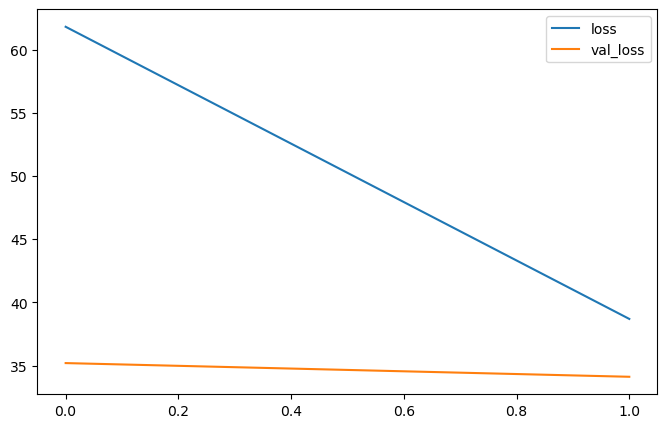

In [ ]:
# Plot the training curves
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/step


<Axes: >

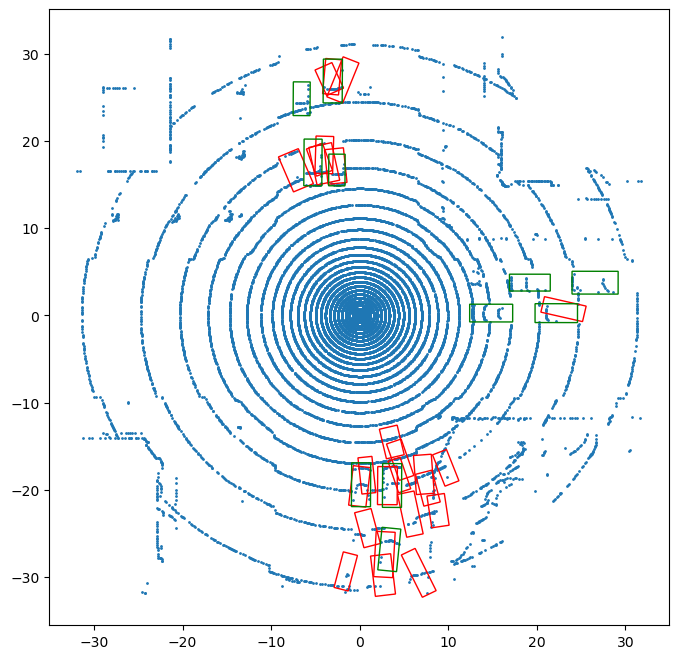

In [ ]:
def decode_predictions(preds, anchors):
    """
    Decodes model predictions into bounding box coordinates and their associated confidence scores.
    Parameters:
        preds (array): Model predictions (shape: Nx(7+num_classes)), including:
                       - First 7 columns: Bounding box regression offsets.
                       - Remaining columns: Class probabilities (logits).
        anchors (array): Anchor boxes corresponding to predictions (shape: Nx7).
    Returns:
        tuple:
            - predicted_boxes (array): Decoded bounding boxes in corner format (shape: Mx8x3, where M is the number of positive predictions).
            - scores (array): Confidence scores for the positive predictions (shape: M).
    """
    boxes_pred = preds[:, :7]
    cls_pred = preds[:, 7:]

    positive_index = cls_pred.argmax(axis=-1) > 0
    scores = softmax(cls_pred, axis=-1)[:, 1]

    # Decode bounding box predictions for anchors with positive class indices
    predicted_boxes = decode_boxes(anchors[positive_index], boxes_pred[positive_index])
    scores = scores[positive_index]
    return predicted_boxes, scores

lidars, target = dataset_val.fetch_single(10)
lidars_voxelized = voxelize(lidars, voxel_size, limit_range, T = maxppgrid)
predictions = model.predict(lidars_voxelized[None])
predicted_boxes, scores = decode_predictions(predictions.squeeze(0), dataset_val.anchors)

ax=vis_point_cloud_2d(lidars, predicted_boxes)
vis_point_cloud_2d(lidars, target, ax=ax, color='g')

<Axes: >

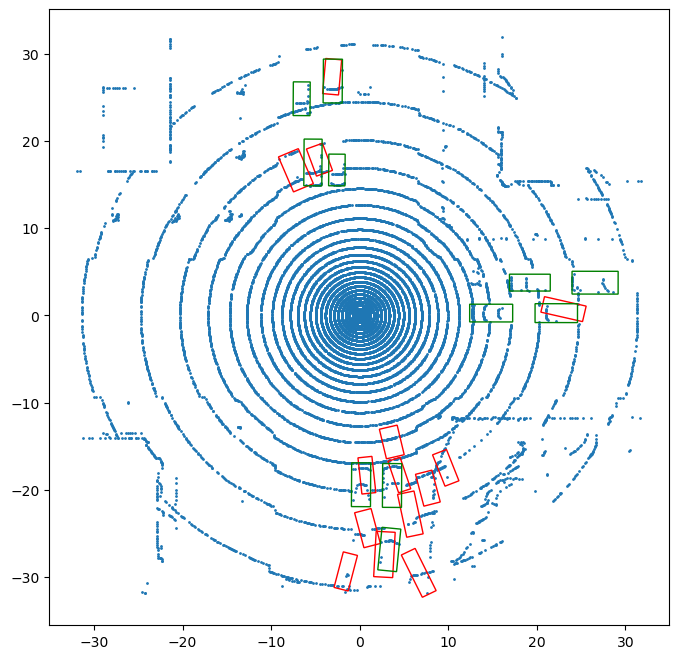

In [ ]:


def nms(boxes, scores, iou_threshold):
    """
    Performs Non-Maximum Suppression (NMS) on predicted bounding boxes.

    NMS is used to filter overlapping bounding boxes by retaining only the
    ones with the highest confidence scores while suppressing others that have
    a high Intersection over Union (IoU) with them.

    Parameters:
        boxes (array): Predicted bounding boxes in corner format (shape: Nx8x3).
        scores (array): Confidence scores for each bounding box (shape: N).
        iou_threshold (float): IoU threshold for suppression. Bounding boxes with IoU
                               above this threshold are suppressed.
    Returns:
        array: Bounding boxes that are kept after applying NMS.
    """
    boxes_poly = np.array([Polygon([(box[i, 0], box[i, 1]) for i in range(4)]) for box in boxes])
    # Sort the indices of the scores in descending order
    B = np.argsort(scores, axis=-1)[::-1] # in descending orders
    keep = []  # Indices of predicted bounding boxes that will be kept

    # Iterate while there are boxes left to process
    while B.size > 0:
        i = B[0] # Pick the box with the highest score (first in the sorted list)
        keep.append(i)
        if B.size == 1: break # If there is only one box left, break the loop
        # Compute IoU between the current box and the remaining boxes
        # iou = box_iou(corner_to_bounding2d(boxes[i:i+1, :]), corner_to_bounding2d(boxes[B[1:], :])).reshape(-1)  # should I use bounding2d here?
        iou = np.array([boxes_poly[i].intersection(b).area / boxes_poly[i].union(b).area for b in boxes_poly[B[1:]]])
        # Find indices of boxes with IoU <= threshold (non-overlapping boxes)
        inds = np.where(iou <= iou_threshold)[0]
        # Update the list of boxes to process, skipping suppressed ones
        B = B[inds + 1] # Shift indices by +1 to account for the current box
    keep_index = np.array(keep)
    boxes = boxes[keep_index] # Return only the boxes corresponding to the kept indices
    scores = scores[keep_index]
    return boxes, scores

filtered_boxes, filtered_scores = nms(predicted_boxes, scores, iou_threshold=0.05)

ax=vis_point_cloud_2d(lidars, filtered_boxes)
vis_point_cloud_2d(lidars, target, ax=ax, color='g')

# Exploration and Evaluation
You will now explore varius hyper parameters (like grid size, max points per grid element) etc.

### Evaluation
In order to do that we first need a more solid way of evaluating our experiments (after NMS).

We will use Average Precision (AP) based on a precision-recall curve as performance measure.

In [ ]:
# Helper function to compute IoU between polygons
def compute_ious(predicted_polygons, target_polygons):
    """
    Compute IoU values between two lists of polygons.
    Args:
        predicted_polygons: List of predicted Shapely Polygons.
        target_polygons: List of ground-truth Shapely Polygons.
    Returns:
        ious: NxM numpy array of IoU values, where N is the number of predicted polygons
              and M is the number of target polygons.
    """
    return np.array([[pred.intersection(gt).area / pred.union(gt).area
                      if not pred.is_empty and not gt.is_empty else 0
                      for gt in target_polygons]
                     for pred in predicted_polygons])

# Function to evaluate performance
def evaluate_performance(predicted_boxes, target, scores, iou_thresh=0.5):
    """
    Evaluate object detection predictions by computing TP, FP, and GT counts.

    Args:
        predicted_boxes: List of predicted bounding boxes (Nx4x2 array of coordinates).
        target: List of ground truth bounding boxes (Mx4x2 array of coordinates).
        scores: Confidence scores for each predicted bounding box.
        iou_thresh: IoU threshold to determine a match.

    Returns:
        fp: List of false positive indicators.
        tp: List of true positive indicators.
        gt: Total number of ground-truth boxes.
        sorted_scores: Confidence scores sorted in descending order.
    """
    # Number of ground-truth boxes
    gt = target.shape[0]

    # Sort predictions by scores in descending order
    score_order_descend = np.argsort(scores)[::-1]
    predicted_boxes = [predicted_boxes[i] for i in score_order_descend]
    scores = [scores[i] for i in score_order_descend]

    # Convert boxes to polygons
    predicted_poly = [Polygon([(box[i, 0], box[i, 1]) for i in range(4)]) for box in predicted_boxes]
    target_poly = [Polygon([(box[i, 0], box[i, 1]) for i in range(4)]) for box in target]

    fp = []
    tp = []

    # Loop through each predicted polygon
    for det_poly in predicted_poly:
        # Compute IoUs with all ground truth polygons
        ious = compute_ious([det_poly], target_poly).squeeze(0)

        if len(target_poly) == 0 or np.max(ious) < iou_thresh:
            fp.append(1)  # False positive
            tp.append(0)
        else:
            fp.append(0)  # True positive
            tp.append(1)

            # Remove matched ground truth polygon
            gt_index = np.argmax(ious)
            target_poly.pop(gt_index)

    return fp, tp, gt, scores

In [ ]:
def calculate_ap(fp, tp, gt, scores):
    """
    Calculate Average Precision (AP) using precision-recall curve.
    Args:
        fp: List of false positives.
        tp: List of true positives.
        gt: Total number of ground-truth boxes.
        scores: Confidence scores of predictions.
    Returns:
        ap: Average Precision score.
    """
    # Sort by scores in descending order
    sorted_index = np.argsort(scores)[::-1]
    fp = np.array(fp)[sorted_index]
    tp = np.array(tp)[sorted_index]

    # Compute cumulative sums
    fp = np.cumsum(fp)
    tp = np.cumsum(tp)

    # Compute recall and precision
    recall = tp / gt if gt > 0 else np.zeros_like(tp)
    precision = tp / (tp + fp)

    # Extend recall and precision for PR curve
    recall = np.concatenate([[0.0], recall, [1.0]])
    precision = np.concatenate([[0.0], precision, [0.0]])

    # Ensure precision is monotonically decreasing
    for i in range(len(precision) - 2, -1, -1):
        precision[i] = max(precision[i], precision[i + 1])

    # Compute area under the precision-recall curve
    ap = 0.0
    for i in range(1, len(recall)):
        ap += (recall[i] - recall[i - 1]) * precision[i]  # Summing the area under the curve
    # Note that ap = np.trapezoid(precision, recall) gives another result
    # https://stats.stackexchange.com/questions/478467/is-it-better-to-compute-average-precision-using-the-trapezoidal-rule-or-the-rect#479235
    return ap

In [ ]:
# Main evaluation loop
n_eval = 25  # Number of evaluation samples out of the 401*0.2 = 80 we have
fp_list = []
tp_list = []
gt_total = 0
scores_list = []

for i in range(n_eval):
    # Fetch and preprocess the data
    lidars, target = dataset_val.fetch_single(i)
    lidars_voxelized = voxelize(lidars, voxel_size, limit_range, T = maxppgrid)
    predictions = model.predict(lidars_voxelized[None],verbose=0)
    predicted_boxes, scores = decode_predictions(predictions.squeeze(0), dataset_val.anchors)
    filtered_boxes, filtered_scores = nms(predicted_boxes, scores, iou_threshold=0.05)

    # Evaluate predictions for this sample
    fp, tp, gt, scores = evaluate_performance(filtered_boxes, target, filtered_scores, iou_thresh=0.5)
    fp_list += fp
    tp_list += tp
    gt_total += gt
    scores_list += scores

# Compute Average Precision
ap = calculate_ap(fp_list, tp_list, gt_total, scores_list)
print(f'AP = {ap:.3f}')  # Output the AP score

# To simplify the experiment results, you should on a single line print
# (besides AP): hyper parameters you have explored, and running time for training

##################### YOUR CODE STARTS HERE ###################

print(f"Hyperparameters: num_epochs={num_epochs}, maxppgrid={maxppgrid}, voxellen={voxel_size}, input_map_size={input_map_size},LearningRate={learning_rate}, Time to run: {end - start:.2f}")
model.summary()

##################### YOUR CODE ENDS HERE #####################

AP = 0.031
Hyperparameters: num_epochs=2, maxppgrid=32, voxellen=[0.8, 0.8, 5.0], input_map_size=32,LearningRate=0.001, Time to run: 55.81


Model: "detector_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vfe_linear (Dense)              │ ?                      │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vfe_linear2 (Dense)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ backbone (Functional)           │ ?                      │       201,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cls (Conv2D)                    │ ?                      │           772 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bbox (Conv2D)                   │ ?                      │         2,702 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 607,704 (2.32 MB)

 Trainable params: 201,394 (786.70 KB)

 Non-trainable params: 3,520 (13.75 KB)

 Optimizer params: 402,790 (1.54 MB)

### Exploration
The code above, has far from optimal hyper parameters (our focus was to get it to run with at least decent results and reasonable running time).

Given the performance criteria AP as defined above, can you find a better set of hyper parameters? How much better (in percent) can you improve our 3D object detector?

We will first set up a few tests that all students should do, and then after that you are free to vary any hyper parameter in the code (model architecture, anchor setup, voxel size, points per grid cell, data augmentation, and more). You should explore at least one more hyper parameter.

Important is to analyse your results and draw some conclusions from your experiments. So were the results as expected, what was the most important (for the performance) hyper parameter you tried, etc.

STUDENT Hyper Parameter Exploration:
* If you **rerun this experiement at least three times** (from the start "run all", or at least from where the model is defined). What can you say about the stability of your results, why are there such variations, how will these vaiation influence the interpretability of your hyper parameter search?
* Explore **maxppgrid** by changing it to 8 and rerun the experiement, did the AP change significantly, did it influence the training time?
* Change back maxppgrid (to 32) and explore **voxellen**, try values 0.8 and 0.4, did the AP change significantly, how many trainable parameters were used, did it influence the training time?
* Change back voxellen and explore **input_map_size** (the size of first hidden layer after input), set that to 48 instead, did the AP change significantly, how many trainable parameters were used, did it influence the training time?
* *As a target I can mention that we during the development of this exercise got to AP=0.75, but the model is still useful with an AP above 0.45.*

STUDENT Additional Hyper Parameter Exploration:
*   Based on the results from above, now explore one additional hyper parameter (best would be to starting from the best set you found above, but it is OK to fall back on the default setup if the runtime is too long for the best setup)



STUDENT Experiment Results:

(ALL test results bellow is using num_epochs = 15)


If you **rerun this experiement at least three times** (from the start "run all", or at least from where the model is defined). What can you say about the stability of your results, why are there such variations, how will these vaiation influence the interpretability of your hyper parameter search?

* First run AP = 0.263 , Time to run: 308.24
* Second run AP AP = 0.356, Time to run: 396.72
* Third run AP = 0.451, Time to run: 337.14


Explore **maxppgrid** by changing it to 8 and rerun the experiement, did the AP change significantly, did it influence the training time?
* First run AP = 0.243 , Time to run: 282.15
* Second run AP = 0.297, Time to run: 278.83
* Third run AP = 0.362, Time to run: 299.99


Change back maxppgrid (to 32) and explore **voxellen**, try values 0.8 and 0.4, did the AP change significantly, how many trainable parameters were used, did it influence the training time?

### voxellen = 0.8 , Total number of trainable parameters: 201394
*  First run AP = 0.275, Time to run: 294.53, 
*  Second run AP = 0.316, Time to run: 296.31 
*  Third run AP = 0.241, Time to run: 311.13

### voxellen = 0.4 , Total number of trainable parameters: 201394
*  First run AP = 0.566 , Time to run: 600.89
* Second run AP = 0.496, Time to run: 635.00
* Third run AP = 0.587, Time to run: 580.62

Change back voxellen and explore **input_map_size** (the size of first hidden layer after input), set that to 48 instead, did the AP change significantly, how many trainable parameters were used, did it influence the training time?

*  First run , AP = 0.446 ,Time to run: 389.42 , Total number of trainable parameters: 206,898
*  Second run AP = 0.318, Time to run: 380.51


STUDENT Additional Hyper Parameter Exploration:
*   Based on the results from above, now explore one additional hyper parameter (best would be to starting from the best set you found above, but it is OK to fall back on the default setup if the runtime is too long for the best setup)

### input_map_size=32 , voxellen = 0.4 , Total number of trainable parameters: 201394
* Tested learning_rate=5e-3 ,AP = 0.405, Time to run: 684.30
* Tested learning_rate=1e-2 , AP = 0.346 , Time to run: 302.53 ( Early stopping kicked in at epoch 6)
* Tested learning_rate=2e-3 , AP = 0.514, Time to run: 438.59

STUDENT Result Analysis:

After rerunning all cells three times, I observed that the AP showed a large variation, ranging from 0.263 to 0.451. The main reason for this is the random initialization of the model weights e.g. in Dense layers every time a new instance of the Detector model is created. Random factors such as batch shuffling and the small dataset size also contribute to this instability. Because of this randomness, it becomes harder to draw strong conclusions when comparing hyperparameter settings small changes in AP may simply be due to random variation rather than real improvements. In practice, this type of variation can be reduced by using predefined random seeds, but in this lab I kept the randomness to illustrate how unstable a stochastic model can be under these conditions and ruuned the tests three times instead.

When I changed maxppgrid to 8 and reran the experiment, the AP again varied due to randomness in range 0.243–0.362. The average AP with maxppgrid = 8 was slightly lower than with maxppgrid = 32, which is expected since each voxel now contains fewer LiDAR points with maxppgrid = 8 instead of 32, reducing the amount of information available to the network. The effect on training time was clearer maxppgrid = 8 consistently resulted in faster training, as there were fewer points per voxel to process. 
In summary reducing maxppgrid speeds up training but slightly reduces AP.

Next, I kept maxppgrid = 32 and explored different voxel sizes voxellen = 0.8 similar training time to default, slightly lower AP.
With voxellen = 0.4 AP improved noticeably (range 0.496–0.566), but the training time almost doubled The number of trainable parameters remained the same 201394 because changing voxellen only affects the BEV grid resolution the number of voxels, not the network architecture. With voxellen = 0.4, the grid becomes much finer with more voxels, and requiring more convolution operations, which explains the significantly increased training time.

When i changed back the voxellen = 0.64 and changed input_map_size to 48, the model architecture changed slightly, increasing the number of trainable parameters to 206898. Training time increased slightly 380–390s, but AP did not significantly improve, staying within the same variation range as the default configuration. Because the improvement was unclear and the compute cost increased.

For the additional hyper parameter exploration, I chose to vary the learning rate. I started from the best configuration I had found so far, with voxellen = 0.4, maxppgrid = 32 and input_map_size = 32. I changed input_map_size back to 32 because increasing it to 48 only gave a very small and unclear improvement in AP, while increasing the number of parameters and the training time. 

I then explored different learning rates. First, I tried higher learning rates than the default 1e-3, with learning_rate = 5e-3, the AP dropped to 0.405 and the training time was about 684 seconds.With learning_rate = 1e-2, early stopping was triggered at epoch 6, and the AP was 0.346 with a training time of about 303 seconds. After that, I tested a smaller increase, learning_rate = 2e-3, which gave an AP of 0.514 and a training time of about 439 seconds. 

For comparison, the default lr = 1e-3 previously achieved higher AP values in range 0.496–0.587 with the same configuration. In all runs, the model used 201394 trainable parameters, since the learning rate does not change the architecture. Overall, increasing or decreasing the learning rate from 1e-3 did not improve AP, and in some cases caused instability or early stopping. Therefore, the default learning rate = 1e-3, together with input_map_size = 32, voxellen = 0.4, remains the best configuration found, offering the most stable and highest performance.I could have implemented automatic hyperparamter search using Grid search or Optuna but felt that was out of this labratory.

# Bonus task

In the model we currently have:
```
x = self.vfe_linear(x) # b, h, w, T, 11 -> b, h, w, T, 32
x = ops.max(x, axis=3, keepdims=False) #  b, h, w, 32

features = self.backbone(x)
```
This "max" operation, seems very "hard". Instead implement a trainable Layer that do this mapping b, h, w, T, 32 -> b, h, w, 32

Evaluate this model on your best hyper parameter setting from previous task.


In [ ]:
# Here you can just show the line(s), that you have updated
##################### YOUR CODE STARTS HERE ###################

# In Detector.__init__ added a second Dense layer for voxel wise aggregation
self.vfe_linear2 = keras.layers.Dense(input_map_size, name="vfe_linear2")         

# In Detector.call i replaced the max polling over T with a trainable dense layer
b = ops.shape(x)[0] 
h = ops.shape(x)[1] 
w = ops.shape(x)[2] 
T = ops.shape(x)[3]
C = ops.shape(x)[4]

# Flatten the T and C dimensions into one per voxel 
x = ops.reshape(x, (b, h, w, T * C)) # (b, h, w, T * input_map_size)
# Adding trainable layer voxel wise aggregation instead of max pooling
x = self.vfe_linear2(x)  #  (b, h, w, input_map_size)

#x = ops.max(x, axis=3, keepdims=False) #  b, h, w, input_map_size
##################### YOUR CODE ENDS HERE #####################

NameError: name 'self' is not defined

STUDENT Questions:
* Did it improve the model (compared to the original "max" method)?
* Why do you think it improved/made it worse?
* How much longer did it take to train (compared to the original "max" method)?

YOUR Answers:

No, the model did not improve. With the original ops.max aggregation I obtained AP values in the range 0.496–0.587, while the new trainable aggregation layer without ops.max produced AP values only in the range 0.337–0.386. This shows that the learned aggregation performed significantly worse than the simple ops.max based method.

The original ops.max is very simple and ops.max naturally selects the strongest signal in a voxel, for example the most discriminative or highest-intensity point, and ignores the rest. This works well for sparse LiDAR data. In contrast, the new trainable aggregation flattens all T × 32 point features in each voxel and applies a Dense layer. 
This introduces more trainable parameters about 201,427 vs 197,536, makes the optimization problem harder with such a small dataset, increases sensitivity to random weight initialization, and can mix informative and non-informative points instead of focusing on the strongest ones. Overall, the added complexity does not help the model here and instead seems to hurt generalization, which explains the lower AP.

The training time was roughly similar. With the trainable aggregation layer, the training time was about 614–655 seconds, compared to 580–635 seconds with ops.max. There was no clear speed advantage of the trainable aggregation, while the AP clearly decreased.